Marcin Wardyński  
Wtorek, 9:45

# **Uczenie Maszynowe - LAB2b - LIME**

Biblioteka LIME: https://github.com/marcotcr/lime (Dokumentacja API: https://lime-ml.readthedocs.io/en/latest/)

# **Wprowadzenie - pakiety**

Niezbędne pakiety i moduły na potrzeby wprowadzenia

In [2]:
import json
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from lime import lime_image
from PIL import Image
from skimage.segmentation import mark_boundaries
from torchvision import models, transforms

/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Wprowadzenie - funkcje pomocnicze

Funkcja do wczytywania wskazanego obrazka oraz konwersji do palety RGB.

In [3]:
def get_image(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

Funkcja do przekształcania obrazka (zwróconego przez funkcję `get_image`) w tensor, akceptowalny na wejściu sieci neronowej.

In [4]:
def image_to_tensor(img):    
    transformer = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])  
    return transformer(img).unsqueeze(0)

Funkcja używana przez LIME, przyjmuje na wejściu zbiór obrazków, a zwraca prawdopodobieństwa klas. Należy ją przekazać do `lime_image.LimeImageExplainer().explain_instance` przy użyciu `partial`, jako `partial(predict_batch, <model>)`, gdzie modelem w naszym wypadku będą sieci neuronowe. Przykłady użycia są zawarte w tym notebooku.

In [5]:
def predict_batch(model, images):
    model.eval()
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]) 
    ])   
    
    model.eval()
    batch = torch.stack(tuple(transformer(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probas = torch.nn.functional.softmax(logits, dim=1)
    return probas.detach().cpu().numpy()

Funkcja, która przekształca obrazek w format akceptowany na wejściu przez LIME. Przykłady użycia są zawarte w tym notebooku.

In [6]:
def lime_transformer(image):
    transformer = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])
    return np.array(transformer(image))

LIME jest głównie wykorzystywane do **wyjaśniania** predykcji tzw. czarnych skrzynek, czyli modeli nieinterpretowalnych. Idealnymi kandydatami są Głębokie Sieci Neuronowe, dlatego spróbujemy wyjaśnić niektóre predykcje gotowych modeli.

# **Model Inception-v3 - przygotowanie danych**
https://arxiv.org/abs/1512.00567

Plik `./data/imagenet_class_index.json` zawiera przypisanie klas obrazków do indeksów. Jest to istotne, ponieważ zwracane wyniki (np. wartości funkcji logit na wyjściu sieci neuronowych) wykorzystują to, zwracając wyniki w zadanej kolejności.

In [7]:
with open("./data/imagenet_class_index.json") as f:
    content = json.load(f)
    index_to_label = {
        int(index): data[1]
        for index, data in content.items()
    }

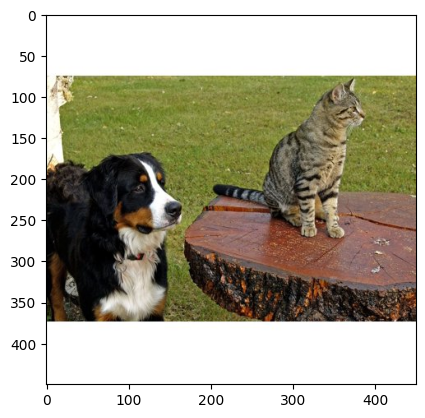

In [8]:
image_to_classify = get_image("./data/dogs.png")
plt.imshow(image_to_classify)

In [9]:
img_tensor = image_to_tensor(image_to_classify)

### **Załadowanie pretrenowanego modelu**

In [10]:
inception_v3 = models.inception_v3(pretrained=True)

/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### **Predykcja**

In [11]:
inception_v3.eval()
logits = inception_v3(img_tensor)

Zwróć uwagę, że model zwraca wartości funkcji logit, a nie prawdopodobieństwa klas, dlatego wyniki trzeba przetworzyć (np. przy użyciu funkcji softmax).

In [12]:
probas = torch.nn.functional.softmax(logits, dim=1)

Sprawdźmy N najbardziej prawdopodobnych klas

In [13]:
TOP_N_LABELS = 15

probas_top = probas.topk(TOP_N_LABELS)
top_probas = probas_top[0][0].detach().numpy()
top_labels = probas_top[1][0].detach().numpy()
for proba, label in zip(top_probas, top_labels):
    print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

Class: Bernese_mountain_dog           | Probability: 0.935930
Class: EntleBucher                    | Probability: 0.038448
Class: Appenzeller                    | Probability: 0.023756
Class: Greater_Swiss_Mountain_dog     | Probability: 0.001818
Class: Gordon_setter                  | Probability: 0.000009
Class: Blenheim_spaniel               | Probability: 0.000007
Class: English_springer               | Probability: 0.000002
Class: tabby                          | Probability: 0.000002
Class: robin                          | Probability: 0.000001
Class: guinea_pig                     | Probability: 0.000001
Class: amphibian                      | Probability: 0.000001
Class: Japanese_spaniel               | Probability: 0.000001
Class: African_grey                   | Probability: 0.000001
Class: Brittany_spaniel               | Probability: 0.000001
Class: toucan                         | Probability: 0.000001


### **Teraz możemy te funkcje zebrać razem**

In [14]:
def get_prediction_probabilities(image, model):
    img_tensor = image_to_tensor(image)
    model.eval()
    logits = model(img_tensor)
    probas = torch.nn.functional.softmax(logits, dim=1)
    
    TOP_N_LABELS = 15

    probas_top = probas.topk(TOP_N_LABELS)
    top_probas = probas_top[0][0].detach().numpy()
    top_labels = probas_top[1][0].detach().numpy()
    for proba, label in zip(top_probas, top_labels):
        print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

### **I sprawdzić jak ta predykcja wygląda dla innego obrazka**

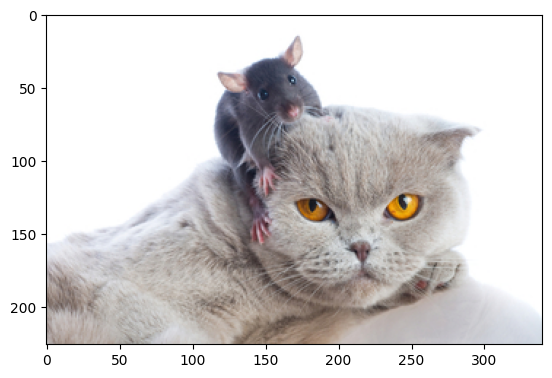

In [15]:
exercise_image = get_image("./data/cat_mouse.jpeg")
plt.imshow(exercise_image)

## **Zadanie: sprawdź jak będzie wyglądała predykcja dla powyższego obrazka**

In [16]:
get_prediction_probabilities(exercise_image, inception_v3)

Class: Egyptian_cat                   | Probability: 0.967492
Class: tabby                          | Probability: 0.024167
Class: lynx                           | Probability: 0.005490
Class: tiger_cat                      | Probability: 0.002165
Class: Persian_cat                    | Probability: 0.000105
Class: Angora                         | Probability: 0.000074
Class: swab                           | Probability: 0.000071
Class: Madagascar_cat                 | Probability: 0.000064
Class: snow_leopard                   | Probability: 0.000040
Class: tile_roof                      | Probability: 0.000037
Class: indri                          | Probability: 0.000020
Class: leopard                        | Probability: 0.000016
Class: Siamese_cat                    | Probability: 0.000011
Class: ram                            | Probability: 0.000010
Class: crate                          | Probability: 0.000009


# **Model Inception-v3 - wyjaśnienie**

Chcemy wiedzieć dlaczego klasa `Bernese_mountain_dog` została uznana przez sieć neuronową za najbardziej prawdopodobną (to znaczy - które piksele obrazka o tym zadecydowały). W tym celu właśnie wykorzystamy LIME.

W jaki sposób działa LIME na obrazkach?
1. Na wejściu wymagany jest oryginalny obrazek.
2. Wejściowy obrazek jest delikatnie przekształcany wiele razy, dzięki czemu otrzymujemy wiele podobnych (ale nie takich samych!) obrazków.
3. Dodatkowo na wejście musimy podać funkcję, która każdemu takiemu przekształceniu nada prawdopodobieństwo przynależności do danej klasy. Jest to wymagane ponieważ LIME jest niezależny od żadnych narzędzi i modeli.

In [17]:
explainer = lime_image.LimeImageExplainer()

In [18]:
explanation = explainer.explain_instance(
    image=lime_transformer(image_to_classify), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

100%|██████████| 1000/1000 [00:31<00:00, 32.16it/s]


Mając te dane możemy teraz sprawdzić które kategorie są najbardziej prawdopodobne

In [19]:
for index in explanation.top_labels:
    print(index_to_label[index])

Bernese_mountain_dog
EntleBucher
Appenzeller
Greater_Swiss_Mountain_dog
Gordon_setter


Zobaczmy co wpłynęło na wybranie `Bernese_mountain_dog` jako najbardziej prawdopodobnej klasy.

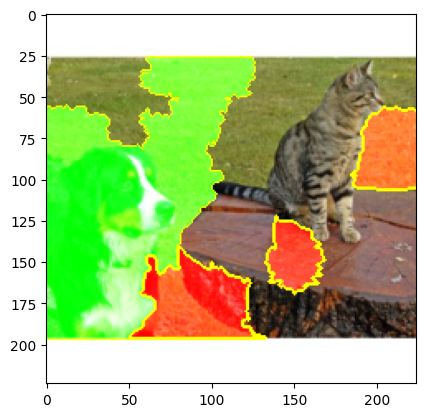

In [20]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

## **Zadanie: zmień wartość NUM_FEATURES i zaobserwuj jak zmienia się mapowanie**
NUM_FEATURES najlepiej zmieniać w zakresie 1:50

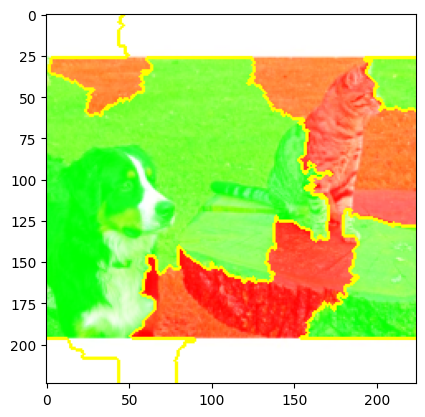

In [21]:
NUM_FEATURES = 50

image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=NUM_FEATURES,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Zielone fragmenty oznaczają "superpiksele", które pozytywnie wpływają na predykowaną klasę. Czerwone fragmenty wpływają negatywnie.

## **Zadanie-pytanie: co to właściwie jest superpiksel?**
## **Zadanie-pytanie: czy jeden superpiksel ma odzwierciedlenie w jednym pikselu z obrazka?**

Superpiksel to zbiór umieszczonych blisko siebie piskeli, które współdzielą pewne właściwości, jak np. kolor.  
Superpiksel nie ma odzwierciedlenia w pojedyńczym pikselu z obrazka, to piksele z obrazka mają odzwierciedlenie w superpikselu.

Zobaczmy jak to się prezentuje dla drugiej najbardziej prawdopodobnej klasy, czyli `EntleBucher`, która jednak otrzymała jedyne 3.8%.

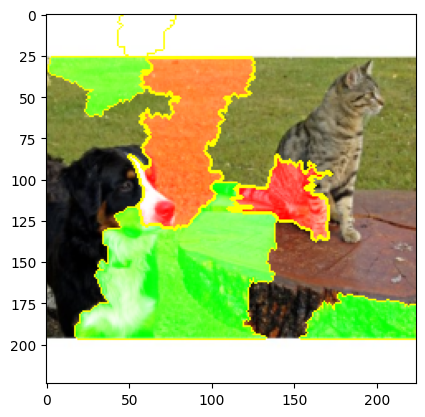

In [22]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[1],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Ustawiając wartości `hide_rest` oraz `positive_only` na `True` jesteśmy w stanie zostawić tylko te piksele, które potwierdzały przynależność do danej klasy <br>
Musimy jednak pamiętać o przeskalowaniu rezultatu przy pomocy `(boundaries).astype(np.uint8)`

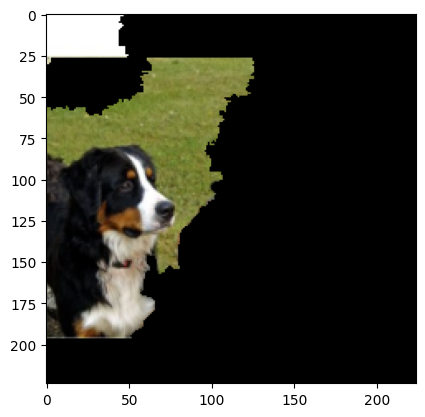

In [23]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=10,
    hide_rest=True)
boundaries = mark_boundaries(image, mask)
plt.imshow((boundaries).astype(np.uint8))

Możemy również zostawić tylko te piksele, które zaprzeczały przynależności do danej klasy

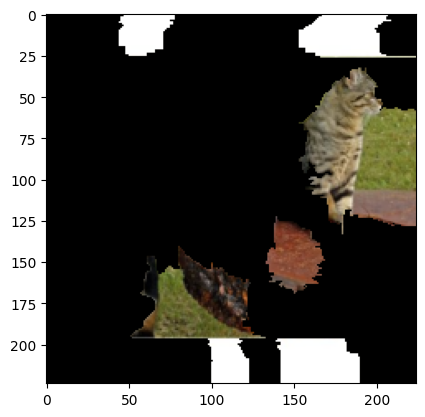

In [24]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=True,
    num_features=10,
    hide_rest=True)
boundaries = mark_boundaries(image, mask)
cropped_image_ndarray = (boundaries).astype(np.uint8)
plt.imshow(cropped_image_ndarray)

A następnie sprawdzić co model sądzi o tak wyciętym obrazku

In [25]:
cropped_image_pil = Image.fromarray(cropped_image_ndarray)

get_prediction_probabilities(cropped_image_pil, inception_v3)

Class: groom                          | Probability: 0.586923
Class: feather_boa                    | Probability: 0.140905
Class: mortarboard                    | Probability: 0.101425
Class: bow_tie                        | Probability: 0.088837
Class: academic_gown                  | Probability: 0.022114
Class: abaya                          | Probability: 0.016757
Class: suit                           | Probability: 0.016571
Class: wig                            | Probability: 0.004465
Class: hoopskirt                      | Probability: 0.003308
Class: kimono                         | Probability: 0.002478
Class: limousine                      | Probability: 0.001725
Class: overskirt                      | Probability: 0.001429
Class: gown                           | Probability: 0.000706
Class: komondor                       | Probability: 0.000694
Class: bonnet                         | Probability: 0.000664


I jak go teraz widzi model

In [26]:
cropped_image_explanation = explainer.explain_instance(
    image=lime_transformer(cropped_image_pil), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

100%|██████████| 1000/1000 [00:28<00:00, 34.53it/s]


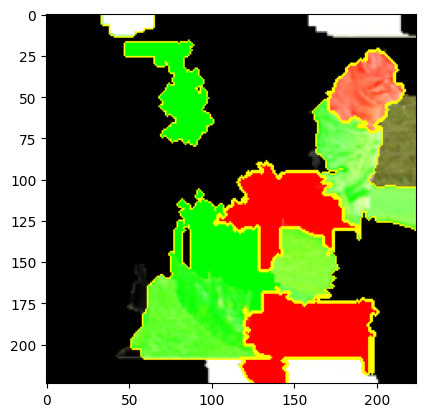

In [27]:
image, mask = cropped_image_explanation.get_image_and_mask(
    label=cropped_image_explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

# **Model Inception-v3 - porównanie z AlexNet**

Przetestujmy działanie na innym modelu - `AlexNet`

In [28]:
alexnet = models.alexnet(pretrained=True)

/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
explanation_alexnet = explainer.explain_instance(
    image=lime_transformer(image_to_classify), 
    classifier_fn=partial(predict_batch, alexnet),
    top_labels=5,
    num_samples=1000)

100%|██████████| 1000/1000 [00:09<00:00, 110.98it/s]


In [30]:
for index_alex, index_inception in zip(explanation_alexnet.top_labels, explanation.top_labels):
    print(f"{index_to_label[index_alex]:30} | {index_to_label[index_inception]:30}")

Bernese_mountain_dog           | Bernese_mountain_dog          
EntleBucher                    | EntleBucher                   
Greater_Swiss_Mountain_dog     | Appenzeller                   
Appenzeller                    | Greater_Swiss_Mountain_dog    
basset                         | Gordon_setter                 


Jak widać, klasy nieco się różnią, ale TOP 1 pozostaje takie samo.

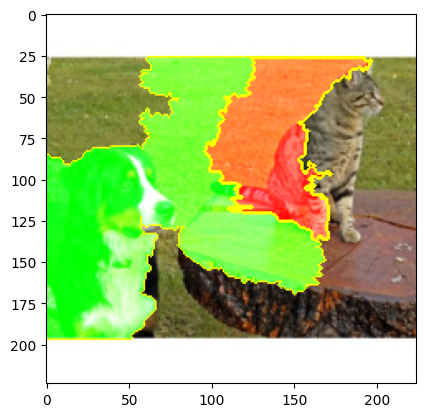

In [31]:
image, mask = explanation_alexnet.get_image_and_mask(
    label=explanation_alexnet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Wyjaśnienie dla `AlexNet` jak się można było spodziewać - też się różni, jednak w dalszym ciągu do klasyfikacji psa istotny jest... pies :)

## **Zadanie: porównaj predykcje obrazka dla modeli inception_v3 oraz alexnet**

In [32]:
print("inception_v3")
get_prediction_probabilities(exercise_image, inception_v3)
print()
print("alexnet")
get_prediction_probabilities(exercise_image, alexnet)

inception_v3
Class: Egyptian_cat                   | Probability: 0.967492
Class: tabby                          | Probability: 0.024167
Class: lynx                           | Probability: 0.005490
Class: tiger_cat                      | Probability: 0.002165
Class: Persian_cat                    | Probability: 0.000105
Class: Angora                         | Probability: 0.000074
Class: swab                           | Probability: 0.000071
Class: Madagascar_cat                 | Probability: 0.000064
Class: snow_leopard                   | Probability: 0.000040
Class: tile_roof                      | Probability: 0.000037
Class: indri                          | Probability: 0.000020
Class: leopard                        | Probability: 0.000016
Class: Siamese_cat                    | Probability: 0.000011
Class: ram                            | Probability: 0.000010
Class: crate                          | Probability: 0.000009

alexnet
Class: Persian_cat                    | Probabil

Jak widzimy powyżej, dla obrazka ćwiczeniowego Alexnet oraz Inception_v3 proponują inne rozwiązania. Zaproponowany z niemalże pewnością przez Inception_v3 "Egyptian_cat" jest na miejscu drugim w Alexnet, ale ze znaczącą stratą do pierwszej klasy, czyli "Persian_cat", który to znowu jest dopiero na miejscu piątym w Inception_v3. 

# **Zadanie domowe - wstęp**
W folderze `data` znajduje się zdjęcie amfibii:
![title](data/amfibia.jpg)


In [126]:
amphibious_vehicle = get_image("./data/amfibia.jpg")

/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1000/1000 [00:31<00:00, 31.89it/s]


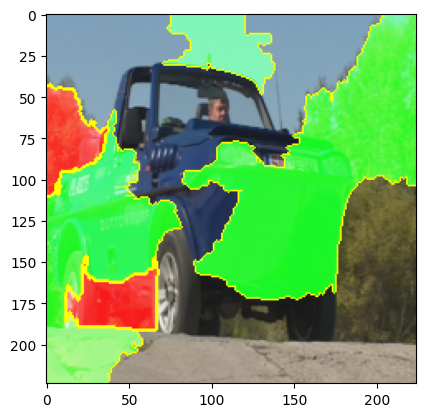

In [34]:
inception_v3 = models.inception_v3(pretrained=True)

explanation_amhibious_vehicle_inception_v3 = explainer.explain_instance(
    image=lime_transformer(amphibious_vehicle), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_amhibious_vehicle_inception_v3.get_image_and_mask(
    label=explanation_amhibious_vehicle_inception_v3.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Model `inception_v3` jak i jego wyjaśnienie rzeczywiście sugerują amfibię jako najbardziej prawdopodobną klasę:

In [35]:
for index in explanation_amhibious_vehicle_inception_v3.top_labels:
    print(index_to_label[index])

amphibian
convertible
racer
car_wheel
golfcart


Dla dalszych zadań użyję zdjęcia pianina, który to poddam podobnej klasyfikacji, jak amfibia powyżej. (Zadania dla amfibii również wykonałem, i znajdują się na końcu notatnika)  
![title](data/upright.jpeg)

In [41]:
upright = get_image("./data/upright.jpeg")

100%|██████████| 1000/1000 [00:30<00:00, 32.50it/s]


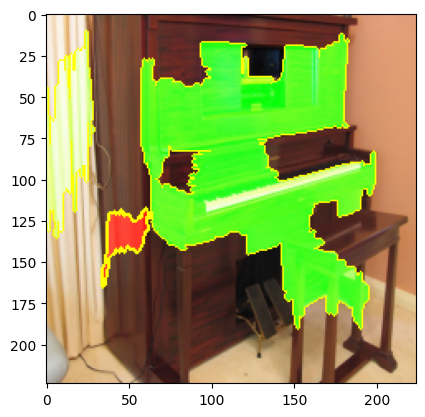

In [42]:
explanation_upright_inception_v3 = explainer.explain_instance(
    image=lime_transformer(upright), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_upright_inception_v3.get_image_and_mask(
    label=explanation_upright_inception_v3.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

In [43]:
for index in explanation_upright_inception_v3.top_labels:
    print(index_to_label[index])

upright
kite
patas
milk_can
grand_piano


Jak widzimy, model słusznie rozpoznaje w obiekcie pianino. Nie dziwi fakt, że zaznaczonym superpikselem o dużej wadze dla klasyfikacji jest klawiatura.

# Zadanie #1

Użyj dwóch różnych sieci neuronowych (poza inception_v3, którego przykład jest powyżej) do wygenerowania wyjaśnień.<br>
(skorzystaj z modułu torchvision: https://pytorch.org/vision/stable/models.html)

/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1000/1000 [00:34<00:00, 28.63it/s]


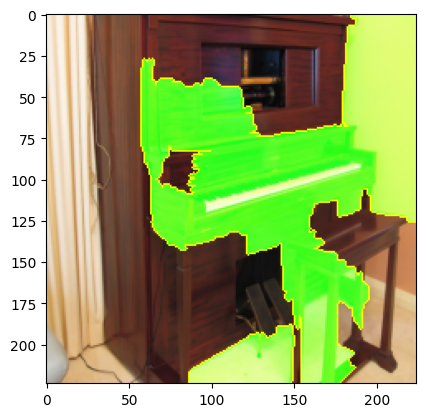

In [44]:
mobilenet_v3_l = models.mobilenet_v3_large(pretrained=True)

explanation_upright_mobilenet_v3_l = explainer.explain_instance(
    image=lime_transformer(upright), 
    classifier_fn=partial(predict_batch, mobilenet_v3_l),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_upright_mobilenet_v3_l.get_image_and_mask(
    label=explanation_upright_mobilenet_v3_l.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

In [45]:
for index in explanation_upright_mobilenet_v3_l.top_labels:
    print(index_to_label[index])

upright
organ
grand_piano
file
entertainment_center


/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1000/1000 [00:31<00:00, 32.02it/s]


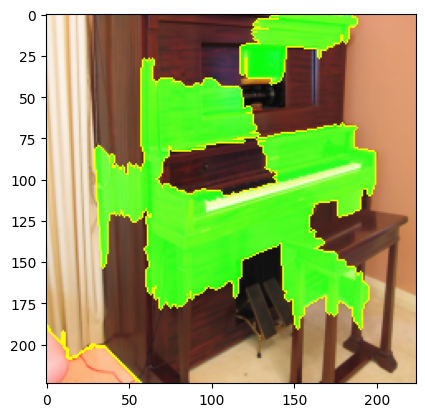

In [46]:
resnet50 = models.resnet50(pretrained=True)

explanation_upright_resnet50 = explainer.explain_instance(
    image=lime_transformer(upright), 
    classifier_fn=partial(predict_batch, resnet50),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_upright_resnet50.get_image_and_mask(
    label=explanation_upright_resnet50.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

In [47]:
for index in explanation_upright_resnet50.top_labels:
    print(index_to_label[index])

upright
grand_piano
organ
file
refrigerator


Jak widzimy powyżej, każdy z modeli zaznacza trochę inny zestaw superpiskeli jako ten najbardziej naprowadzający na daną klasę obiektu, jednakże widać dużą zbieżność pomiędzy superpikselami zaznaczonymi przez każdy z modeli. Każdy zaznaczyl klawiaturę.

Wszystkie modele skutecznie zaklasyfikowały obiekt jako pianino, a nowo-wybrane modele okazały się o tyle lepsze od InceptionV3, że kolejne ich predykcje po tej najbardziej prawdopodobnej również dotyczyły intrumentów klawiszowych, podczas gdy InceptionV3 wskazywał obiekty z bardzo różnych kategorii.

# Zadanie #2

Zmodyfikuj oryginalny obrazek w taki sposób, żeby najbardziej prawdopodobną klasą dla każdej z tych sieci **nie była** amfibia a jakiś inny pojazd (np. samochód). W tym celu możesz "zasłonić" czarnym kwadratem (wartość 0 w macierzy reprezentującej obraz) obszary istotne przy klasyfikacji. <br>
Przydatną rzeczą będzie skorzystanie z opcji `hide_rest` w funkcji `get_image_and_mask` i późniejsza obróbka obrazu

In [49]:
def calculate_rectagle_covering(mask):
    width = mask.shape[0]
    height = mask.shape[1]
    min_x, min_y = width, height
    max_x, max_y = 0, 0

    for x in range(width):
        for y in range(height):
            px = mask[y][x]
            
            if px == 1:
                if x < min_x:
                    min_x = x
                if y < min_y:
                    min_y = y
                if x > max_x:
                    max_x = x
                if y > max_y:
                    max_y = y
    return (min_x, min_y), (max_x, max_y)

def cover_image_with_rectangle(mask, image):
    rectangle = calculate_rectagle_covering(mask)
    
    lime_image = lime_transformer(image)
    lime_image[rectangle[0][1]:rectangle[1][1]+1, rectangle[0][0]:rectangle[1][0]+1] = [0, 0, 0]
    return lime_image

100%|██████████| 1000/1000 [00:28<00:00, 34.78it/s]


microwave
upright
entertainment_center
television
safe


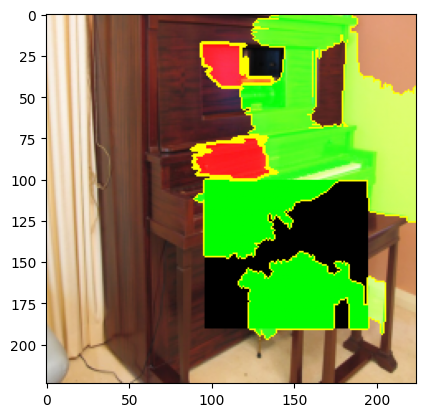

In [50]:
num_features=1

image, mask = explanation_upright_inception_v3.get_image_and_mask(
    label=explanation_upright_inception_v3.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=num_features,
    hide_rest=True)

covered_lime_image = cover_image_with_rectangle(mask, upright)

explanation_covered_upright_inception_v3 = explainer.explain_instance(
    image=covered_lime_image, 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_covered_upright_inception_v3.get_image_and_mask(
    label=explanation_covered_upright_inception_v3.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

for index in explanation_covered_upright_inception_v3.top_labels:
    print(index_to_label[index])


100%|██████████| 1000/1000 [00:32<00:00, 31.23it/s]

home_theater
entertainment_center
upright
television
file


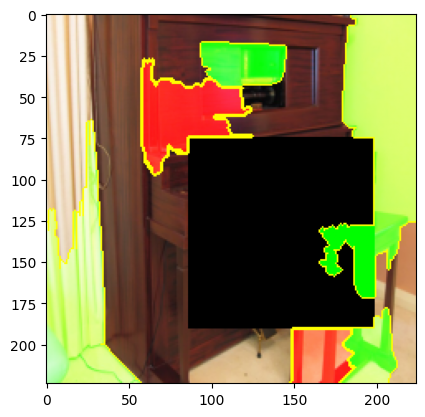

In [53]:
num_features=3

image, mask = explanation_upright_mobilenet_v3_l.get_image_and_mask(
    label=explanation_upright_mobilenet_v3_l.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=num_features,
    hide_rest=True)

covered_lime_image = cover_image_with_rectangle(mask, upright)

explanation_covered_upright_mobilenet_v3_l = explainer.explain_instance(
    image=covered_lime_image, 
    classifier_fn=partial(predict_batch, mobilenet_v3_l),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_covered_upright_mobilenet_v3_l.get_image_and_mask(
    label=explanation_covered_upright_mobilenet_v3_l.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

for index in explanation_covered_upright_mobilenet_v3_l.top_labels:
    print(index_to_label[index])


100%|██████████| 1000/1000 [00:31<00:00, 32.22it/s]

entertainment_center
home_theater
television
desktop_computer
fire_screen


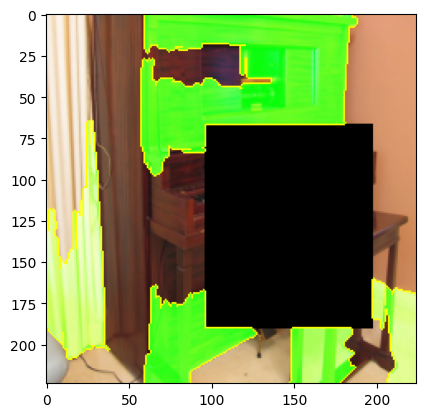

In [55]:
num_features=2

image, mask = explanation_upright_resnet50.get_image_and_mask(
    label=explanation_upright_resnet50.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=num_features,
    hide_rest=True)

covered_lime_image = cover_image_with_rectangle(mask, upright)

explanation_covered_upright_resnet50 = explainer.explain_instance(
    image=covered_lime_image, 
    classifier_fn=partial(predict_batch, resnet50),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_covered_upright_resnet50.get_image_and_mask(
    label=explanation_covered_upright_resnet50.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

for index in explanation_covered_upright_resnet50.top_labels:
    print(index_to_label[index])


To zadanie pokazuje jak bardzo zróżnicowane są wybrane trzy modele klasyfikujące:

InceptionV3 już po zasłonięciu pierwszego co do istotności dla klasyfikacji superpiksela zmienił klasę przedmiotu na mikrofalówkę, wskazując pianino na drugim miejscu. Warto zauważyć, że po zasłonięciu tego superpiksela, klawiatura jest wciąż widoczna, a więc najbardziej charakterystyczny element instrumentu dostrzegany przez człowieka nie jest tożsamy z najbardziej znaczącym elementem dla modelu.

MobileNetV3 wykazał się ciekawym zachowaniem i dość dużą odpornością, jak na mały model do zastosowań mobilnych. Otóż dopiero po usunięciu obszaru odpowiadającemu trzem najważniejszym superpikselom podał pianino dopiero jako trzecią propozycję klasyfikacji, natomiast wyżej oceniona została szansa na to, że obrazek przedtawia kino domowe lub centrum rozrywki domowej. Co ciekawe, przy późniejszym testowaniu obrazka z amfibią, model MobileNetV3 dał się zwieść najszybciej wśród testowanych modeli, więc ewidentnie dużo zależy od miejsca ulokowania zasłaniającego kwadratu oraz istotności pozostałych superpikseli.

ResNet ustopił po zasłonięciu dwóch pierwszych superpikseli i w tym momencie pianino wypadło z TOP5 proponowanych klas przedmiotu ze zdjęcia.

Warto dodać, że w każdym z analizowanych przypadków, ważne superpiksele stanowiły skupiska, a więc przy usuwaniu kolejnych z nich obszar przykryty czarnym kwadratem powiększał się tylko niewiele.



# Zadanie #3

Ponownie zmodyfikuj oryginalny obraz, ale tym razem zaszumiając go w losowy sposób (przykładowa implementacja: https://www.geeksforgeeks.org/add-a-salt-and-pepper-noise-to-an-image-with-python/). Czy najbardziej prawdopodobna klasa zmienia się wraz ze zmianą szumu? Przetestuj dla każdego z modeli.

In [104]:
import random 
import cv2 
  
def add_noise(img): 
  
    # Getting the dimensions of the image 
    row , col = img.shape 
      
    # Randomly pick some pixels in the 
    # image for coloring them white 
    # Pick a random number between 300 and 10000 
    number_of_pixels = random.randint(300000, 300000) 
    for i in range(number_of_pixels): 
        
        # Pick a random y coordinate 
        y_coord=random.randint(0, row - 1) 
          
        # Pick a random x coordinate 
        x_coord=random.randint(0, col - 1) 
          
        # Color that pixel to white 
        img[y_coord][x_coord] = 255
          
    # Randomly pick some pixels in 
    # the image for coloring them black 
    # Pick a random number between 5000 and 10000 
    number_of_pixels = random.randint(300000 , 300000) 
    for i in range(number_of_pixels): 
        
        # Pick a random y coordinate 
        y_coord=random.randint(0, row - 1) 
          
        # Pick a random x coordinate 
        x_coord=random.randint(0, col - 1) 
          
        # Color that pixel to black 
        img[y_coord][x_coord] = 0
          
    return img 
  


In [75]:
img = cv2.imread('./data/sp4_upright.jpeg', 
                 cv2.IMREAD_GRAYSCALE) 
  
#Storing the image 
cv2.imwrite('./data/sp5_upright.jpeg', 
            add_noise(img))

True

100%|██████████| 1000/1000 [00:28<00:00, 35.25it/s]


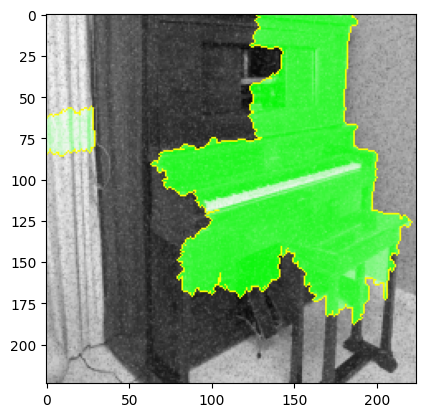

In [117]:
sp_upright = get_image("./data/sp5_upright.jpeg")

explanation_sp_upright_inception_v3 = explainer.explain_instance(
    image=lime_transformer(sp_upright), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_sp_upright_inception_v3.get_image_and_mask(
    label=explanation_sp_upright_inception_v3.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

In [118]:
for index in explanation_sp_upright_inception_v3.top_labels:
    print(index_to_label[index])

upright
kite
patas
milk_can
grand_piano


100%|██████████| 1000/1000 [00:30<00:00, 32.85it/s]


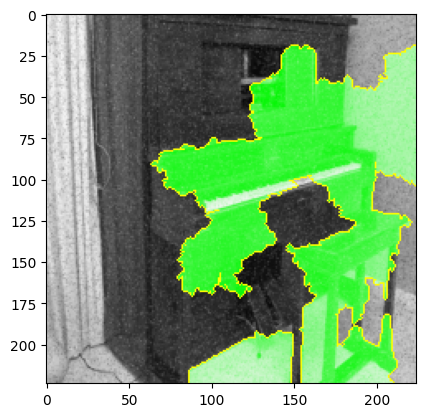

In [115]:
sp_upright = get_image("./data/sp5_upright.jpeg")

explanation_sp_upright_mobilenet_v3_l = explainer.explain_instance(
    image=lime_transformer(sp_upright), 
    classifier_fn=partial(predict_batch, mobilenet_v3_l),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_sp_upright_mobilenet_v3_l.get_image_and_mask(
    label=explanation_sp_upright_mobilenet_v3_l.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

In [116]:
for index in explanation_sp_upright_mobilenet_v3_l.top_labels:
    print(index_to_label[index])

upright
grand_piano
file
television
stove


100%|██████████| 1000/1000 [00:30<00:00, 32.32it/s]


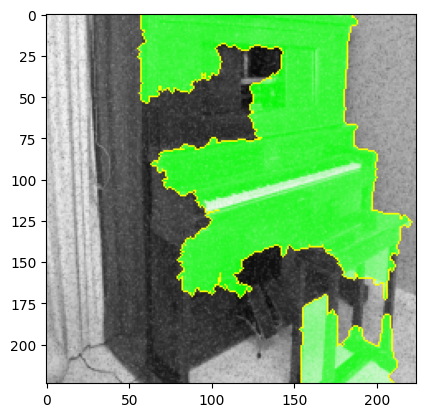

In [113]:
sp_upright = get_image("./data/sp5_upright.jpeg")

explanation_sp_upright_resnet50 = explainer.explain_instance(
    image=lime_transformer(sp_upright), 
    classifier_fn=partial(predict_batch, resnet50),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_sp_upright_resnet50.get_image_and_mask(
    label=explanation_sp_upright_resnet50.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

In [114]:
for index in explanation_sp_upright_resnet50.top_labels:
    print(index_to_label[index])

upright
grand_piano
file
organ
accordion


W przeprowadzanym powyżej ćwiczeniu, żaden z modeli nie popełnił błędu przy klasyfikacji piania z obrazka po jego zaszumieniu. Co więcej, obrazek został zaszumiony pięciokrotnie i wszystki modele wciąż były w stanie rozpoznać pianino. Dodam, że każde standardowe zaszumienie, zamienia do 5000px na punkty czarne i do 5000px na punkty białe.

Wynik ten jest dla mnie zaskoczeniem, ponieważ w eksperymencie z amfibią (którego wyniki można znaleźć poniżej), jednokrotne zaszumienie wystarczyło, żeby model  ResNet nie zaklasyfikował pojazdu z obrazka poprawnie. InceptionV3 i MobileNetV3 w przypadku zaszumionej amfibii były bezbłędne, również przy pięciokrotnym zaszumieniu.

Ewidentnie, wybrane przeze mnie zdjęcie pianina dostarcza wystarczającą liczbę jakościowych superpikseli charakterystycznych dla pianina, żeby klasyfikator nie popełnił błędu nawet przy sporym zaszumieniu obrazka. Mówiąc wprost: obecność pianina na zdjęciu jest ewidentne.

### Dodatkowe zaszumianie

Będąc ciekaw dalszej odporności na zaszumianie, zmieniłem program zaszumiający, tak żeby zamieniał dokładnie 300.000 losowych pikseli na białe i tą samą ilość na czarne punkty. Ta ilość wystarczyła, żeby wprowadzić w błąd wszystkie modele.

Natomiast jeszcze przy 200.000 białych i czarnych losowych pikselach, przy klasyfikacji mylił się tylko model MobileNetV3. To ciekaw, że model o największej odporności na zakłócenia przy zasłanianiu czarnym kwadratem poddał się jako pierwszy przy zaszumianiu. Najwyraźniej radzi sobie on lepiej, gdy pewne fragmenty obiektu nie są widoczne, natomiast nie gdy cały obraz zostanie zniekształcony.

## Podsumowanie

Przedstawione powyżej przypadki w bardzo dobry sposób przedstawiają przydatność narzędzia LIME do analizowania istotności superpikseli dla jakości klasyfikacji.  
Analiza ta pozwala w kontrolowany sposób porównać ze sobą różne modele i ujawnić ich mocne oraz słabe strony.  
Narzędzie pokazuje również, że modele rozpoznające obiekty na zdjęciach nie zawsze kierują się takimi samymi kryteriami jak człowiek, choć w pewnych przypadkach widać podobieństwo pomiędzy ML i człowiekiem.

## Zadanie 1 - Amfibia

100%|██████████| 1000/1000 [00:32<00:00, 30.93it/s]

amphibian
racer
tow_truck
convertible
car_wheel


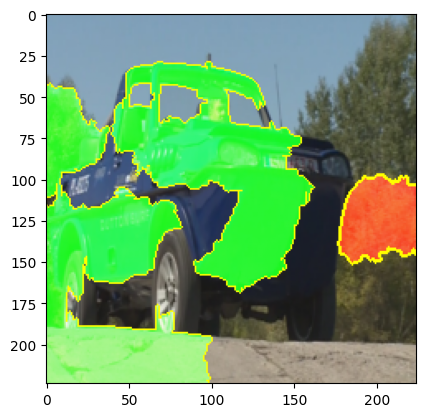

In [119]:
explanation_amhibious_vehicle_mobilenet_v3_l = explainer.explain_instance(
    image=lime_transformer(amphibious_vehicle), 
    classifier_fn=partial(predict_batch, mobilenet_v3_l),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_amhibious_vehicle_mobilenet_v3_l.get_image_and_mask(
    label=explanation_amhibious_vehicle_mobilenet_v3_l.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

for index in explanation_amhibious_vehicle_mobilenet_v3_l.top_labels:
    print(index_to_label[index])

100%|██████████| 1000/1000 [00:32<00:00, 30.41it/s]

amphibian
racer
car_wheel
sports_car
pickup


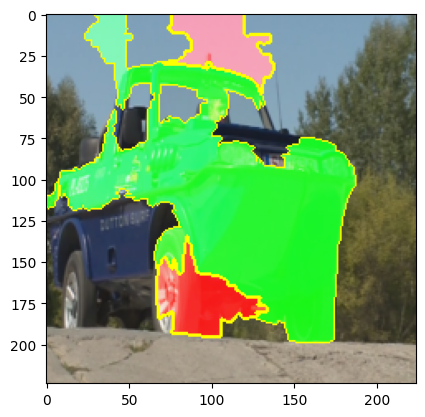

In [120]:
explanation_amhibious_vehicle_resnet50 = explainer.explain_instance(
    image=lime_transformer(amphibious_vehicle), 
    classifier_fn=partial(predict_batch, resnet50),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_amhibious_vehicle_resnet50.get_image_and_mask(
    label=explanation_amhibious_vehicle_resnet50.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

for index in explanation_amhibious_vehicle_resnet50.top_labels:
    print(index_to_label[index])



Jak widzimy powyżej, każdy z modeli zaznacza trochę inny zestaw superpiskeli jako ten najbardziej naprowadzający na daną klasę pojazdu, jednakże widać dużą zbieżność pomiędzy superpikselami zaznaczonymi przez każdy z modeli.

Wszystkie modele skutecznie zaklasyfikowały pojazd jako amfibię.

## Zadanie 2 - Amfibia

100%|██████████| 1000/1000 [00:27<00:00, 36.34it/s]

grand_piano
television
stove
screen
scoreboard


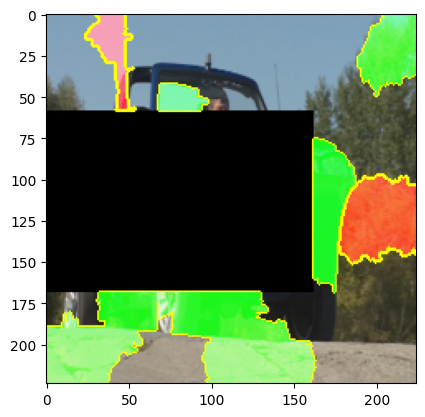

In [127]:
num_features=2

image, mask = explanation_amhibious_vehicle_inception_v3.get_image_and_mask(
    label=explanation_amhibious_vehicle_inception_v3.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=num_features,
    hide_rest=True)

covered_lime_image = cover_image_with_rectangle(mask, amphibious_vehicle)

explanation_c_amhibious_vehicle_inception_v3 = explainer.explain_instance(
    image=covered_lime_image, 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_c_amhibious_vehicle_inception_v3.get_image_and_mask(
    label=explanation_c_amhibious_vehicle_inception_v3.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

for index in explanation_c_amhibious_vehicle_inception_v3.top_labels:
    print(index_to_label[index])


100%|██████████| 1000/1000 [00:27<00:00, 36.60it/s]


racer
amphibian
car_wheel
convertible
sports_car


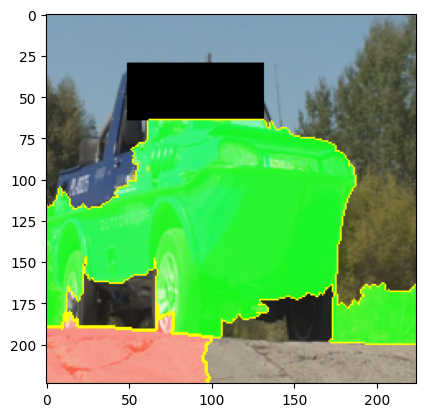

In [122]:
num_features=1

image, mask = explanation_amhibious_vehicle_mobilenet_v3_l.get_image_and_mask(
    label=explanation_amhibious_vehicle_inception_v3.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=num_features,
    hide_rest=True)

covered_lime_image = cover_image_with_rectangle(mask, amphibious_vehicle)

explanation_c_amhibious_vehicle_mobilenet_v3_l = explainer.explain_instance(
    image=covered_lime_image, 
    classifier_fn=partial(predict_batch, mobilenet_v3_l),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_c_amhibious_vehicle_mobilenet_v3_l.get_image_and_mask(
    label=explanation_c_amhibious_vehicle_mobilenet_v3_l.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

for index in explanation_c_amhibious_vehicle_mobilenet_v3_l.top_labels:
    print(index_to_label[index])


100%|██████████| 1000/1000 [00:31<00:00, 31.90it/s]

wreck
tractor
pickup
amphibian
tow_truck


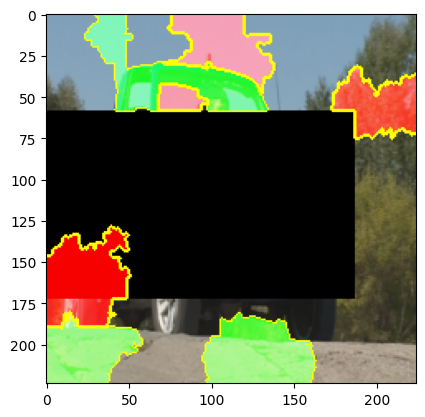

In [123]:
num_features=3

image, mask = explanation_amhibious_vehicle_resnet50.get_image_and_mask(
    label=explanation_amhibious_vehicle_inception_v3.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=num_features,
    hide_rest=True)

covered_lime_image = cover_image_with_rectangle(mask, amphibious_vehicle)

explanation_c_amhibious_vehicle_resnet50 = explainer.explain_instance(
    image=covered_lime_image, 
    classifier_fn=partial(predict_batch, resnet50),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_c_amhibious_vehicle_resnet50.get_image_and_mask(
    label=explanation_c_amhibious_vehicle_resnet50.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

for index in explanation_c_amhibious_vehicle_resnet50.top_labels:
    print(index_to_label[index])

Widzimy powyżej, że wystarczyło przykryć czarnym prostokątem obszar zawierający najbardziej znaczący superpiksel przy klasyfikacji modelem MobileNetV3, żeby go zwieść i otrzymać klasyfikację "racer"

Modele InceptionV3 i ResNet wykazały się największą odpornością. Przy przykryciu odpowiednio dwóch i trzech superpikseli popełniły błąd w klasyfikacji.

## Zadanie 3 - Amfibia

In [ ]:
# salt-and-pepper noise can 
# be applied only to grayscale images 
# Reading the color image in grayscale image 
img = cv2.imread('./data/amfibia.jpg', 
                 cv2.IMREAD_GRAYSCALE) 
  
#Storing the image 
cv2.imwrite('./data/sp_amfibia.jpg', 
            add_noise(img))

In [140]:
sp_amphibious_vehicle = get_image("./data/sp_amfibia.jpg")

100%|██████████| 1000/1000 [00:28<00:00, 35.51it/s]

amphibian
tow_truck
jeep
pickup
snowplow


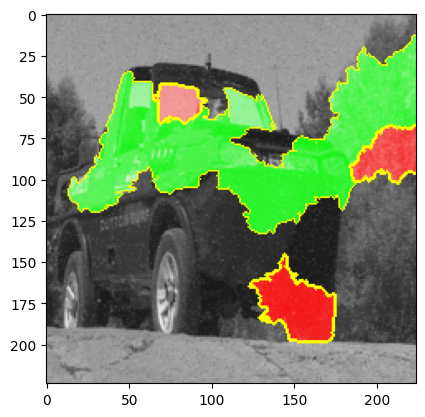

In [129]:
explanation_amphibious_vehicle_inception_v3 = explainer.explain_instance(
    image=lime_transformer(sp_amphibious_vehicle), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_amphibious_vehicle_inception_v3.get_image_and_mask(
    label=explanation_amphibious_vehicle_inception_v3.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

for index in explanation_amphibious_vehicle_inception_v3.top_labels:
    print(index_to_label[index])

100%|██████████| 1000/1000 [00:39<00:00, 25.08it/s]

amphibian
tow_truck
snowplow
half_track
racer


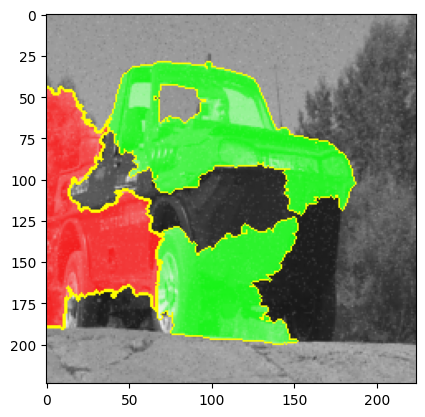

In [141]:
explanation_sp_amhibious_vehicle_mobilenet_v3_l = explainer.explain_instance(
    image=lime_transformer(sp_amphibious_vehicle), 
    classifier_fn=partial(predict_batch, mobilenet_v3_l),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_sp_amhibious_vehicle_mobilenet_v3_l.get_image_and_mask(
    label=explanation_sp_amhibious_vehicle_mobilenet_v3_l.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

for index in explanation_sp_amhibious_vehicle_mobilenet_v3_l.top_labels:
    print(index_to_label[index])

100%|██████████| 1000/1000 [00:31<00:00, 31.42it/s]

jeep
Model_T
pickup
amphibian
snowplow


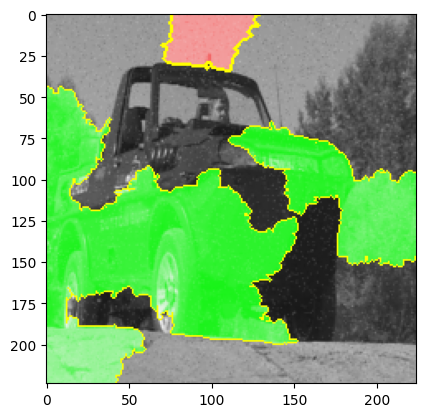

In [131]:
explanation_sp_amhibious_vehicle_resnet50 = explainer.explain_instance(
    image=lime_transformer(sp_amphibious_vehicle), 
    classifier_fn=partial(predict_batch, resnet50),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_sp_amhibious_vehicle_resnet50.get_image_and_mask(
    label=explanation_sp_amhibious_vehicle_resnet50.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

for index in explanation_sp_amhibious_vehicle_resnet50.top_labels:
    print(index_to_label[index])

Po zaszumieniu oryginalnego obrazu możemy zauważyć, że modele InceptionV3 oraz MobileNetV3 poradziły sobie z właściwą klasyfikacją pojazdu. Model  ResNet-50 wskazał błędnie "jeep".

Modele InceptionV3 i MobileNetV3 testowałem dalej po kolejnych zaszumieniach obrazu, ale nawet po pięciokrotnym zaaplikowaniu skryptu dodającego szum, modele rozpoznawały amfibię z obrazka prawidłowo.